# Statistics from Sim dataset and HRV dataset

This module provides an approach to merge the HRV dataset with the SIM dataset.

## Datasets

- **hrv_time_freq_5_min**
  - Dataset with time domain and frequency domain features
  - 927 instances of intervals of 5 minutes
  - Contains filenames for association with SIM data
  - Not labeled

- **hrv_time_freq_2_min**
  - Dataset with time domain and frequency domain features
  - 2371 instances of intervals of 2 minutes
  - Contains filenames for association with SIM data
  - Not labeled

- **sim_data_timer_kss**
  - Each instance represents an instant (in seconds) in the simulation
  - Each instance is associated with one filename
  - Each instance is labeled with KSS value

## Problems

- The duration of each HRV filename recording is different from each SIM recording
- SIM data have timestamps, but HRV data do not

## Approach

1. Group the SIM dataset into intervals of 5 minutes and 2 minutes.
2. Merge the SIM data in the middle of the HRV recording by filename.
3. Merge the SIM data at the beginning of the HRV recording by filename.
4. Merge the SIM data at the end of the HRV recording by filename.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [6]:
def calculate_duration_stats(data_HRV: pd.DataFrame, data_Sim: pd.DataFrame) -> pd.DataFrame:
    """
    get duration for each recording of both datasets
    
    Parameters:
        data_HRV: HRV data with Interval_Start, Interval_End, and Filename.
        data_Sim: sim data with timer [s] and Filename.
    
    Returns:
        dataframe with duration statistics for each Filename.
    """
    
    # duration of each instance of the hrv dataset
    data_HRV['Duration_hrv'] = data_HRV['Interval_End'] - data_HRV['Interval_Start']

    # total duration for each Filename in the hrv dataset
    hrv_duration_stats = data_HRV.groupby('Filename')['Duration_hrv'].agg('sum').rename('Duration_HRV')

    # get the duration in the sim dataset as the difference between the max and min timer [s] by filename
    sim_duration_stats = data_Sim.groupby('Filename')['timer [s]'].agg(['min', 'max', 'mean', 'sum'])
    sim_duration_stats['Duration_sim'] = sim_duration_stats['max'] - sim_duration_stats['min']

    # merge
    combined_stats = pd.merge(hrv_duration_stats, sim_duration_stats[['Duration_sim']], on='Filename', how='outer')

    return combined_stats , hrv_duration_stats , sim_duration_stats[['Duration_sim']]

In [3]:
def get_unique_kss_values(data_Sim: pd.DataFrame) -> pd.Series:
    """
    Get unique values of KSS 
    
    Parameters:
        data_Sim : sim data with kss_answer
    
    Returns:
        dataframe with unique KSS values.
    """
    # count each unique value
    kss_counts = data_Sim['kss_answer'].value_counts().sort_index()
    
    # convert to df
    kss_counts_df = kss_counts.reset_index()
    kss_counts_df.columns = ['KSS_Value', 'Count']
    
    return kss_counts_df

In [4]:
def calculate_duration_supervised(data_supervised: pd.DataFrame) -> pd.DataFrame:
    """
    Get duration of supervised data for filename
    
    Parameters:
        data_supervised: df with HRV and Sim data 
    
    Returns:
        df with duration statistics for each Filename
    """
    # duration of each instance
    data_supervised['Duration'] = data_supervised['Interval_End'] - data_supervised['Interval_Start']
    
    # total duration for each Filename 
    final_duration_stats = data_supervised.groupby('Filename')['Duration'].agg('sum').rename('Duration_Final')
    
    return final_duration_stats.reset_index()

## Load Data

In [5]:
# load HRV dataset 5 min
file_path_HRV= 'datasets/hrv/hrv_time_freq_5_min.csv'
data_HRV = pd.read_csv(file_path_HRV, delimiter=',')

## Sim  ##

# load Sim dataset
file_path_Sim = 'datasets/sim/sim_data_timer_kss.csv'
data_Sim = pd.read_csv(file_path_Sim, delimiter=',')

# load Sim dataset valid
file_path_Sim_valid = 'datasets/sim/sim_data_timer_kss_valid.csv'
data_Sim_valid = pd.read_csv(file_path_Sim_valid, delimiter=',')

# hrv original duration
file_path_dur = 'datasets/hrv/hrv_duration.csv'
data_dur = pd.read_csv(file_path_dur, delimiter=',')

# filtered ECGs duration
file_path_filtered_34 = 'datasets/hrv/filtered_ECG_duration.csv'
data_filtered = pd.read_csv(file_path_filtered_34, delimiter=',')

# load Sim dataset filered
file_path_Sim_filterd = 'datasets/sim/sim_filtered_durations.csv'
data_Sim_filtered = pd.read_csv(file_path_Sim_filterd, delimiter=',')

## Results

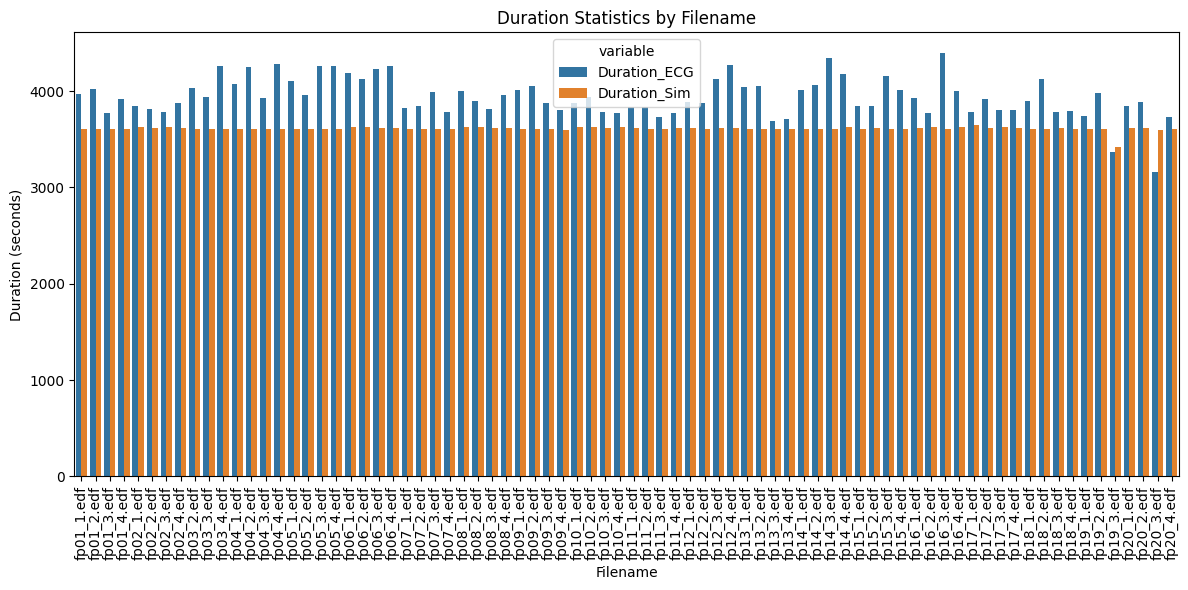

In [8]:
# get duration for each recording of both datasets
combined_stats1, hrv_duration_stats, sim_duration_stats = calculate_duration_stats(data_HRV, data_Sim)

combined_stats = pd.merge(sim_duration_stats, data_dur, on=['Filename'])

combined_stats

combined_stats.rename(columns={'Duration_sim': 'Duration_Sim'}, inplace=True)
combined_stats.rename(columns={'Duration': 'Duration_ECG'}, inplace=True)

# Convert to long format for seaborn
stats_long = combined_stats.reset_index().melt(id_vars='Filename', value_vars=['Duration_ECG','Duration_Sim'])

plt.figure(figsize=(12, 6))

sns.barplot(data=stats_long, x='Filename', y='value', hue='variable')
plt.title('Duration Statistics by Filename')
plt.xlabel('Filename')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

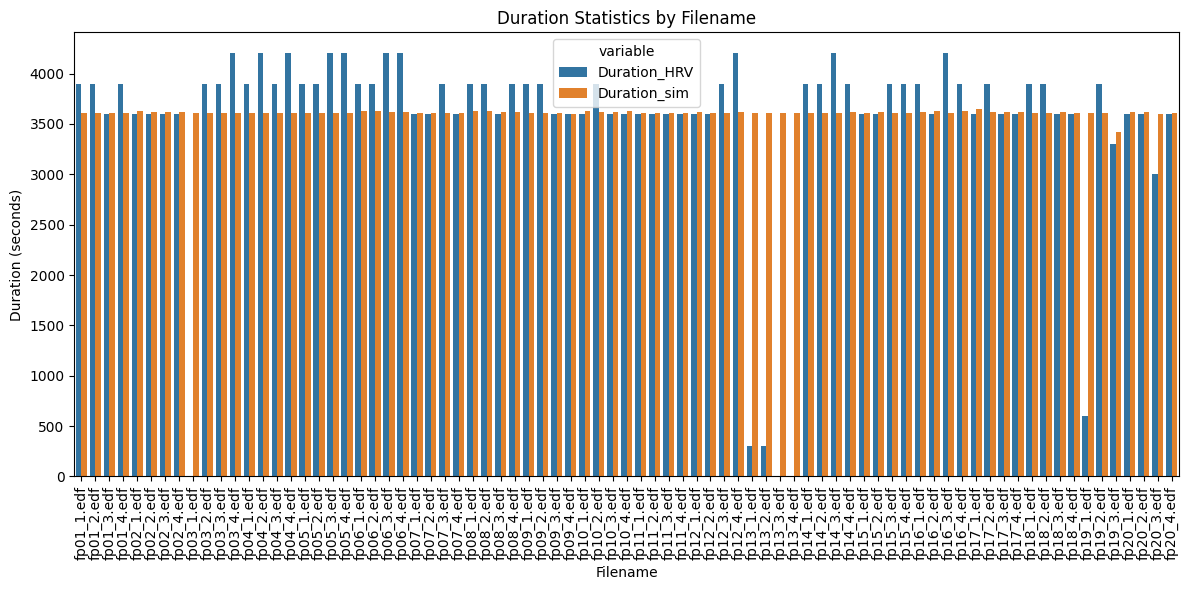

In [10]:
# get duration for each recording of both datasets
combined_stats = calculate_duration_stats(data_HRV, data_Sim)

# Convert to long format for seaborn
stats_long = combined_stats.reset_index().melt(id_vars='Filename', value_vars=['Duration_HRV', 'Duration_sim'])

plt.figure(figsize=(12, 6))

sns.barplot(data=stats_long, x='Filename', y='value', hue='variable')
plt.title('Duration Statistics by Filename')
plt.xlabel('Filename')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Save results

In [1]:
# # save
#combined_stats.to_csv('datasets/stats/stats_HRV_KSS.csv', index=False)

## KKS Values 

In [10]:
unique_kss_values = get_unique_kss_values(data_Sim)
unique_kss_values

,KSS_Value,Count
0,-1,13863
1,2,75378
2,3,1173184
3,4,1819409
4,5,2434011
5,6,2277572
6,7,2183365
7,8,1715092
8,9,2570503


In [11]:
unique_kss_values_valid = get_unique_kss_values(data_Sim_valid)
unique_kss_values_valid

,KSS_Value,Count
0,2,75378
1,3,1173184
2,4,1819409
3,5,2434011
4,6,2277572
5,7,2183365
6,8,1715092
7,9,2570503


## Load Supervised Data

In [12]:
# load supervised start 2 min
file_path_supervised_2_min = 'datasets/supervised/supervised_HRV_KSS_2_min.csv'
data_supervised_2_min = pd.read_csv(file_path_supervised_2_min, delimiter=',')

# load supervised start 5 min
file_path_supervised_5_min = 'datasets/supervised/supervised_HRV_KSS_5_min.csv'
data_supervised_5_min = pd.read_csv(file_path_supervised_5_min, delimiter=',')

### Plot durations to compare

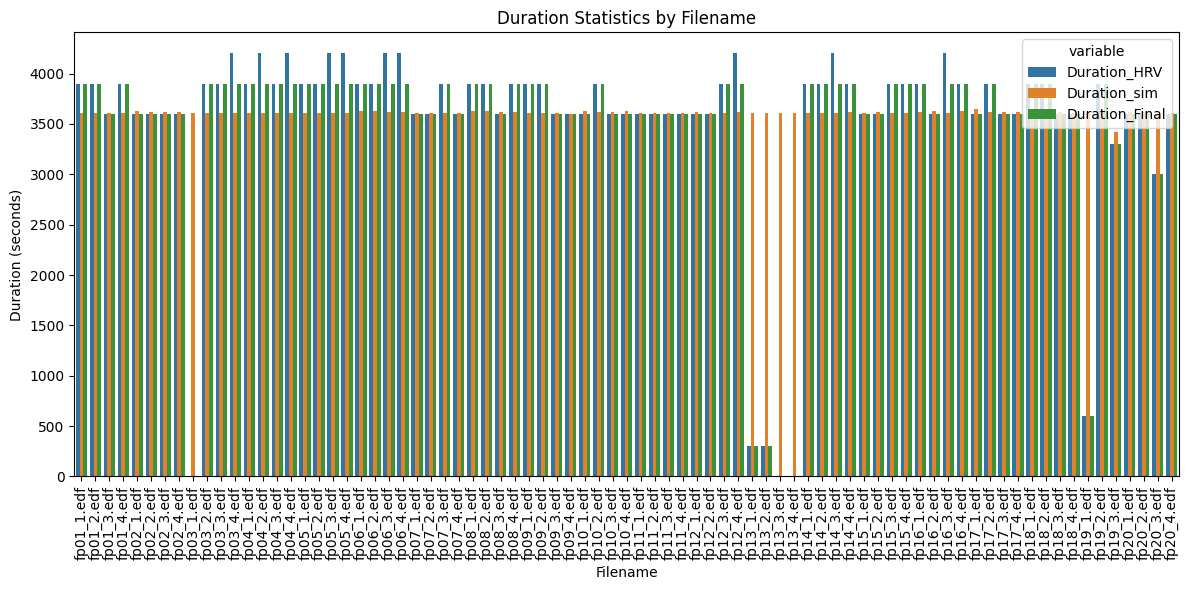

In [15]:
final_duration_stats = calculate_duration_supervised(data_supervised_5_min)

# Merge the final_duration_stats with the existing combined_stats
combined_stats_final = pd.merge(combined_stats, final_duration_stats, on='Filename', how='outer')

# Convert to long format for seaborn
stats_long_final = combined_stats_final.reset_index().melt(id_vars='Filename', value_vars=['Duration_HRV', 'Duration_sim', 'Duration_Final'])

# Plot
plt.figure(figsize=(12, 6))

sns.barplot(data=stats_long_final, x='Filename', y='value', hue='variable')
plt.title('Duration Statistics by Filename')
plt.xlabel('Filename')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Filtered ECG With Marker

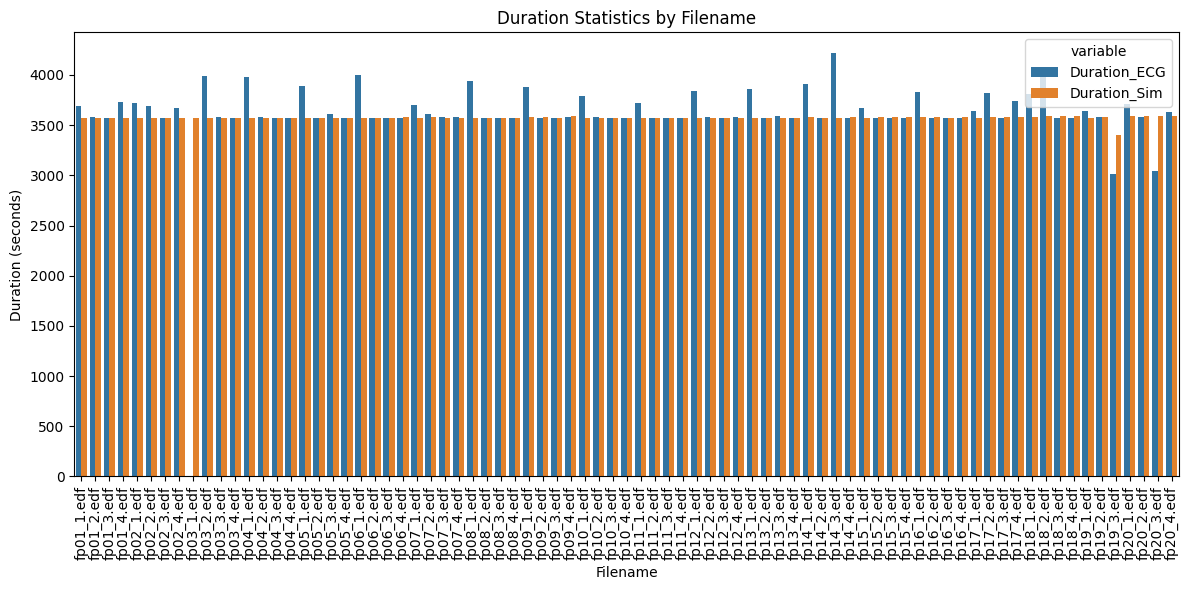

In [35]:
# merge
mergeFilteredData = pd.merge(data_filtered, data_Sim_filtered, on='Filename', how='outer')

mergeFilteredData.rename(columns={'Duration_x': 'Duration_ECG'}, inplace=True)
mergeFilteredData.rename(columns={'Duration_y': 'Duration_Sim'}, inplace=True)

mergeFilteredData

# Convert to long format for seaborn
stats_long = mergeFilteredData.reset_index().melt(id_vars='Filename', value_vars=['Duration_ECG', 'Duration_Sim'])

plt.figure(figsize=(12, 6))

sns.barplot(data=stats_long, x='Filename', y='value', hue='variable')
plt.title('Duration Statistics by Filename')
plt.xlabel('Filename')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()
